# Train and save a version of the model (v1):
- Target encoding with 16d tickets
- approximate grouping (not sure how the data would look like in the future in the database)

In [ ]:
# imports
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
import shap
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import warnings
warnings.filterwarnings('ignore')

/anaconda/envs/azureml_py310_sdkv2_dup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The scikit-learn version is 1.3.0.


## Data information provided by the business:
* __CUSTOMER_SERIAL_NO:__ Serial No is a Manitou system assigned number for each customer id.  
* __CUSTOMER_ID:__ Customer ID is more important as it refers to the customer or transmitter sending the information. Typically the Customer ID is the same as the AT&T Geo Location Code (GLC). The Customer ID’s that are not AT&T GLC’s are system accounts that are monitored for issues, outages, etc. or default accounts for alarms that were not programmed correctly.
* __RLP:__ This is the receiver line prefix and relays information on how the signal is transmitting to Manitou. Anything with an R1 is transmitting via Bosch or similar fire panel communicator. Anything with 99 is transmitting through a BMS system (Apogee, Andover, Niagara, etc.)
* __TX_ID:__ This is the transmitter ID and further helps to identify how the site is communicating. Examples -A = Apogee, -D = Desigo, -VR = Veeder Root. For BMS or Access systems the TXID will contain the AT&T GLC. For other communicator types the TXID will be the assigned account number. There are some Customer ID’s that will have 3 or more transmitter ID’s. Example: Site has Andover for Access Controls, Apogee for the BMS, and Bosch for fire and/or BMS redundancy.
* __EVENT_DATE:__ Event time.
* __EVENT_CODE:__ Event code is directly related to the Alarm_Description. UT = Untyped Zone Trouble, BA = Burglary Alarm, ** = Unknown Event, etc.
* __ALARM_DESCRIPTION:__ 
* __AREA:__ Area details are specific to fire panel programming and are site specific. There is not a dictionary that details what these are. These are similar to zones for BMS alarms.
* __ZONE:__ This is also site specific programming. Each alarm that comes in must have a unique zone and must clear on the same zone.
* __ALRAM_DETAIL:__ This is another site specific programming item and typically references the equipment, space, room, that the alarm has occurred for. Anything that has an address should be a Controller Offline alarm which may mean that either the BMS and/or Access Controller is offline.
* __COMMENT:__ comments agent make on alarms (may contain ticket numbers) 

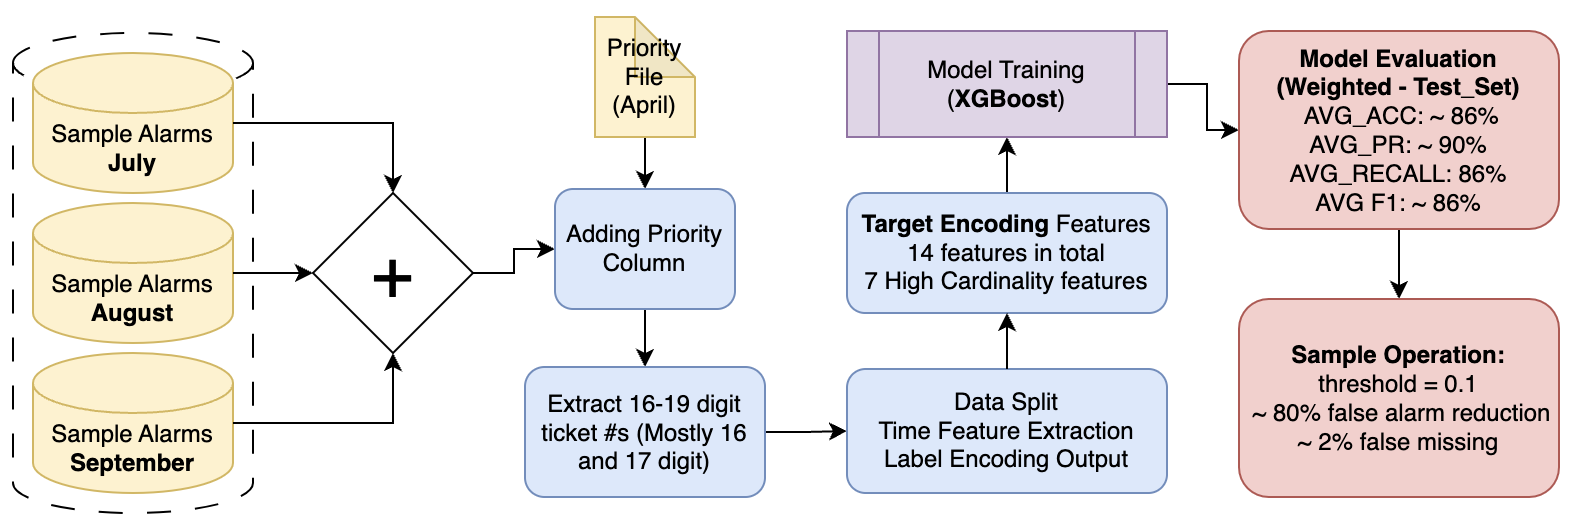

In [163]:
# Sample data uploaded (3 month)
data_1 = pd.read_csv('./ATT_Sample_Data/att_sample_data_raw.csv')
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167276 entries, 0 to 167275
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   CUSTOMER_SERIAL_NO  167276 non-null  int64 
 1   CUSTOMER_ID         167276 non-null  object
 2   RLP                 167276 non-null  object
 3   TX_ID               165683 non-null  object
 4   EVENT_DATE          167276 non-null  object
 5   EVENT_CODE          167276 non-null  object
 6   ALARM_DESCRIPTION   167276 non-null  object
 7   AREA                31108 non-null   object
 8   ZONE                161187 non-null  object
 9   ALARM_DETAIL        149074 non-null  object
 10  COMMENT             154014 non-null  object
 11  COMMENT_LOGDATE     154113 non-null  object
dtypes: int64(1), object(11)
memory usage: 15.3+ MB


In [164]:
# deriving a priority column (based on best of knowledge -> priority file provided)
# this a crude approximation since no priority column is provided in the data
data_1['priority'] = 'H'
inds = data_1[data_1.EVENT_CODE.isin(['DI','DI1','DI2','ET1','*T2','DV','FT','*FT','TB1'])].index
data_1.loc[data_1.index.isin(inds),"priority"]= 'L'

In [165]:
data_1[['CUSTOMER_ID','RLP','TX_ID','EVENT_CODE','ALARM_DESCRIPTION','AREA','ZONE','ALARM_DETAIL'
        ,'COMMENT','priority']] = data_1[['CUSTOMER_ID','RLP','TX_ID','EVENT_CODE','ALARM_DESCRIPTION','AREA','ZONE','ALARM_DETAIL','COMMENT','priority']].astype(str)

In [166]:
data_1.head(10)

,CUSTOMER_SERIAL_NO,CUSTOMER_ID,RLP,TX_ID,EVENT_DATE,EVENT_CODE,ALARM_DESCRIPTION,AREA,ZONE,ALARM_DETAIL,COMMENT,COMMENT_LOGDATE,priority
0,1,SYS-REC1,R1,0,2023-07-01 01:26:02,UT,Untyped Zone Trouble,nan,7,nan,nan,NaN,H
1,1,SYS-REC1,R1,0,2023-07-02 04:23:13,UT,Untyped Zone Trouble,nan,7,nan,nan,NaN,H
2,1,SYS-REC1,R1,0,2023-07-03 05:57:58,UT,Untyped Zone Trouble,nan,7,nan,fc,2023-07-03 05:58:36,H
3,1,SYS-REC1,R1,0,2023-07-03 19:26:05,UT,Untyped Zone Trouble,nan,7,nan,nan,NaN,H
4,1,SYS-REC1,R1,0,2023-07-05 23:32:04,UT,Untyped Zone Trouble,nan,7,nan,fc,2023-07-05 23:33:21,H
5,1,SYS-REC1,R1,0,2023-07-06 19:28:39,UT,Untyped Zone Trouble,nan,7,nan,nan,NaN,H
6,1,SYS-REC1,R1,0,2023-07-07 01:22:47,UT,Untyped Zone Trouble,nan,7,nan,nan,NaN,H
7,1,SYS-REC1,R1,0,2023-07-07 11:22:03,UT,Untyped Zone Trouble,nan,7,nan,nan,NaN,H
8,1,SYS-REC1,R1,0,2023-07-08 00:35:51,UT,Untyped Zone Trouble,nan,7,nan,fc,2023-07-08 00:36:21,H
9,1,SYS-REC1,R1,0,2023-07-08 07:51:52,UT,Untyped Zone Trouble,nan,7,nan,fc,2023-07-08 07:52:42,H


In [167]:
data_1.nunique()

CUSTOMER_SERIAL_NO      4042
CUSTOMER_ID             4042
RLP                        2
TX_ID                   5248
EVENT_DATE             67867
EVENT_CODE                77
ALARM_DESCRIPTION        327
AREA                      34
ZONE                    2353
ALARM_DETAIL           19417
COMMENT                90905
COMMENT_LOGDATE       122840
priority                   2
dtype: int64

In [168]:
# Seems this approximate column does not pass the smell test as majority is H
data_1.priority.value_counts(normalize=True)

priority
H    0.706664
L    0.293336
Name: proportion, dtype: float64

In [169]:
# 'COMMENT_LOGDATE' not useful for predictions
# 'CUSTOMER_SERIAL_NO' seems to be reducndant (keeping 'CUSTOMER_ID')
data_1 = data_1.drop(['CUSTOMER_SERIAL_NO','COMMENT_LOGDATE'], axis=1)

In [170]:
# Obtaining labels for dispatch by info provided by the business
# logic: if comment column contains a ticket number
def get_ticket_info(txt):
    # sequence of exactly 16 digits that is not preceded or followed by any other digit
    str_exp = r'(?<!\d)\d{16}(?!\d)'
    tickets = re.findall(str_exp, txt)
    tickets = [item.strip() for item in tickets]
    return len(tickets)>0
    
data_1['ticket'] = data_1['COMMENT'].astype('str').apply(get_ticket_info)

data_1['ticket'].value_counts(normalize=True)

ticket
False    0.741206
True     0.258794
Name: proportion, dtype: float64

In [193]:
# features and target for classification model
feature_cols = ['CUSTOMER_ID', 'RLP', 'TX_ID', 'EVENT_CODE',
       'ALARM_DESCRIPTION', 'AREA', 'ZONE', 'ALARM_DETAIL', 'priority']

feature_cols = ['CUSTOMER_ID','ALARM_DESCRIPTION']

target = 'ticket'
X, Y = data_1[feature_cols], data_1[target].astype(int)

In [194]:
def split_data(features, target, test_ratio):
    
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=test_ratio, train_size=1-test_ratio, random_state=7, shuffle=True, stratify=target)
    
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data(X, Y, test_ratio=0.2)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(133820, 2) (33456, 2) (133820,) (33456,)


In [195]:
def target_encode(x_train, x_test, y_train, cat_cols):
    
    target_encoder = TargetEncoder().fit(x_train[cat_cols],y_train)
    
    x_train_enc = pd.DataFrame(target_encoder.transform(x_train[cat_cols]), columns = cat_cols)
    x_test_enc = pd.DataFrame(target_encoder.transform(x_test[cat_cols]), columns = cat_cols)
    
    x_train_enc = pd.concat([x_train_enc, x_train.drop(cat_cols,axis=1)], axis=1)
    x_test_enc = pd.concat([x_test_enc, x_test.drop(cat_cols,axis=1)], axis=1)
    
    return x_train_enc, x_test_enc

# all columns are catergorical
cat_cols = list(x_train.columns)
x_train_enc, x_test_enc = target_encode(x_train, x_test, y_train, cat_cols)

In [196]:
def train_model(x_train_enc, y_train):
    xgb = XGBClassifier(random_state = 7)
    xgb.fit(x_train_enc,y_train, sample_weight=compute_sample_weight("balanced", y_train))
    return xgb

In [197]:
def get_prediction(model, features):
    return model.predict(features), model.predict_proba(features)

In [198]:
def metrics_plot(model, x_train_enc, x_test_enc, y_train, y_test):
    
    y_train_pred, y_train_score = get_prediction(model, x_train_enc)
    y_test_pred, y_test_score = get_prediction(model, x_test_enc)
    
    actual, predicted, actual_te, predicted_te = y_train, y_train_pred, y_test, y_test_pred
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    fig.suptitle('Classification results for train and test')
    
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not Critical', 'Critical'], yticklabels = ['Not Critical', 'Critical'], ax=axes[0])
    axes[0].set_title('Train')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    cm_te = confusion_matrix(actual_te, predicted_te)
    sns.heatmap(cm_te, annot = True, fmt = '.2f', xticklabels = ['Not Critical', 'Critical'], yticklabels = ['Not Critical', 'Critical'], ax=axes[1])
    axes[1].set_title('Test')
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')
    
    plt.show()
    
    print(f'+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++\n',
          classification_report(actual, predicted),
          f'\n+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++\n',
          classification_report(actual_te, predicted_te))

In [199]:
def adjusted_metrics_plot(model, x_train_enc, x_test_enc, y_train, y_test):
    
    y_train_pred, y_train_score = get_prediction(model, x_train_enc)
    y_test_pred, y_test_score = get_prediction(model, x_test_enc)
    
    actual, predicted_prob, actual_te, predicted_prob_te = y_train, y_train_score[:,1], y_test, y_test_score[:,1]

    precision, recall, thresholds = precision_recall_curve(actual, predicted_prob)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    best_threshold, best_fscore = thresholds[ix], fscore[ix]
    print(f'best_thr: {best_threshold}\nbest_fscore: {best_fscore}')
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    fig.suptitle('Classification results for train and test')
    
    y_pred_adj = np.where(predicted_prob >= best_threshold, 1,0)
    cm = confusion_matrix(actual, y_pred_adj)
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not Critical', 'Critical'], yticklabels = ['Not Critical', 'Critical'], ax=axes[0])
    axes[0].set_title('Train')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    
    y_pred_adj_te = np.where(predicted_prob_te >= best_threshold, 1,0)
    cm_te = confusion_matrix(actual_te, y_pred_adj_te)
    sns.heatmap(cm_te, annot = True, fmt = '.2f', xticklabels = ['Not Critical', 'Critical'], yticklabels = ['Not Critical', 'Critical'], ax=axes[1])
    axes[1].set_title('Test')
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')
    
    plt.show()
    
    print(f'+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++\n',
          classification_report(actual, y_pred_adj),
          f'\n+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++\n',
          classification_report(actual_te, y_pred_adj_te))

In [200]:
def get_decile_analysis(scores, labels):
    ticks = np.arange(0,1.1,.1)
    ints, critical_cnt, all_cnt = [], [], []
    for i in range(len(ticks)-1):
        ints.append(f'{np.round(ticks[i],2)}-{np.round(ticks[i+1],2)}')
        inds = (scores >= ticks[i]) & (scores <ticks[i+1])
        temp_labels = labels[inds]
        critical_cnt.append(sum(temp_labels))
        all_cnt.append(len(temp_labels))    
    return np.array(ints), np.array(critical_cnt), np.array(all_cnt)

In [201]:
def performance_summary(model, x_train_enc, x_test_enc, y_train, y_test, vectorizer=None):
    
    y_train_pred, y_train_score = get_prediction(model, x_train_enc)
    y_test_pred, y_test_score = get_prediction(model, x_test_enc)
    
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_score[:, 1])
    fscore = (2 * precisions * recalls / (precisions + recalls))
    
    print(f'+++++++++++++++++++++++ PERICISION/RECALL CURVE (TRAIN) +++++++++++++++++++++++\n')
    plt.figure()
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, fscore[:-1], 'r--', label = 'fscore')
    plt.axvline(x=thresholds[np.argmax(fscore)], color='black', ls='-')
    plt.axvline(x=0.5, color='black', ls='-')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0, 1])
    plt.grid('minor')
    plt.show()
    
    print(f'\n ++++++++++++++++++++++++++++++++++++++++++++++ ROC-AUC ++++++++++++++++++++++++++++++++++++++++++++++\n')
    print(f"rocauc_train: {roc_auc_score(y_train, y_train_score[:, 1])}")
    print(f"rocauc_test: {roc_auc_score(y_test, y_test_score[:, 1])}")
    
    print(f'\n ++++++++++++++++++++++++++++++++++++++++++++++ CONFUSION MTX ++++++++++++++++++++++++++++++++++++++++++++++\n')
    metrics_plot(model, x_train_enc, x_test_enc, y_train, y_test)
    adjusted_metrics_plot(model, x_train_enc, x_test_enc, y_train, y_test)
    
    print(f'\n++++++++++++++++++++++++++++++++++++++++++++++ FEATURE IMPORTANCE ++++++++++++++++++++++++++++++++++++++++++++++\n')
    plt.figure(figsize=(18,3))
    pd.Series(model.feature_importances_, index=x_train_enc.columns).nlargest(80).plot(kind='bar')
    plt.ylabel('features')
    plt.xlabel('importance')
    plt.grid('minor')
    plt.show()
    
    print(f'\n++++++++++++++++++++++++++++++++++++++++++++++ DECILE ANALYSIS ++++++++++++++++++++++++++++++++++++++++++++++\n')
    ints, critical_cnt, all_cnt = get_decile_analysis(y_test_score[:,1], y_test)
    plt.figure(figsize=(12,4))
    ax = sns.lineplot(x=ints[::-1], y=critical_cnt[::-1]/all_cnt[::-1], marker="o")
    ax.tick_params(axis='x', rotation=45)
    ax.set(xlabel='(model) probability interval', ylabel='class 1 (important) density (percentage)')
    plt.grid('minor')
    plt.show()
    
    graph_df = pd.DataFrame(zip(ints[::-1],critical_cnt[::-1],all_cnt[::-1]-critical_cnt[::-1]), columns=['interval','critical_cnt','non-critical_cnt']).set_index('interval')
    fig, ax = plt.subplots(figsize = (12, 4))
    graph_df.plot(kind='bar', stacked=True, color=['red','blue'], ax=ax)
    plt.ylabel('counts')
    plt.xlabel('(model) probability interval')
    plt.grid('minor')
    plt.show()

In [202]:
x_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133820 entries, 0 to 133819
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CUSTOMER_ID        133820 non-null  float64
 1   ALARM_DESCRIPTION  133820 non-null  float64
dtypes: float64(2)
memory usage: 2.0 MB


In [203]:
xgb = train_model(x_train_enc, y_train)

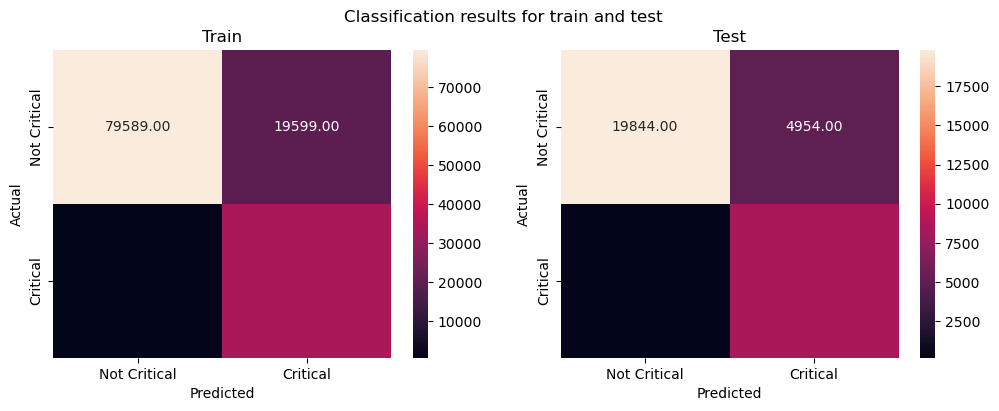

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.99      0.80      0.89     99188
           1       0.63      0.98      0.77     34632

    accuracy                           0.85    133820
   macro avg       0.81      0.89      0.83    133820
weighted avg       0.90      0.85      0.86    133820
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.99      0.80      0.89     24798
           1       0.63      0.98      0.77      8658

    accuracy                           0.85     33456
   macro avg       0.81      0.89      0.83     33456
weighted avg       0.90      0.85      0.86     33456



In [204]:
metrics_plot(xgb, x_train_enc, x_test_enc, y_train, y_test)

best_thr: 0.6607804894447327
best_fscore: 0.7762224710712953


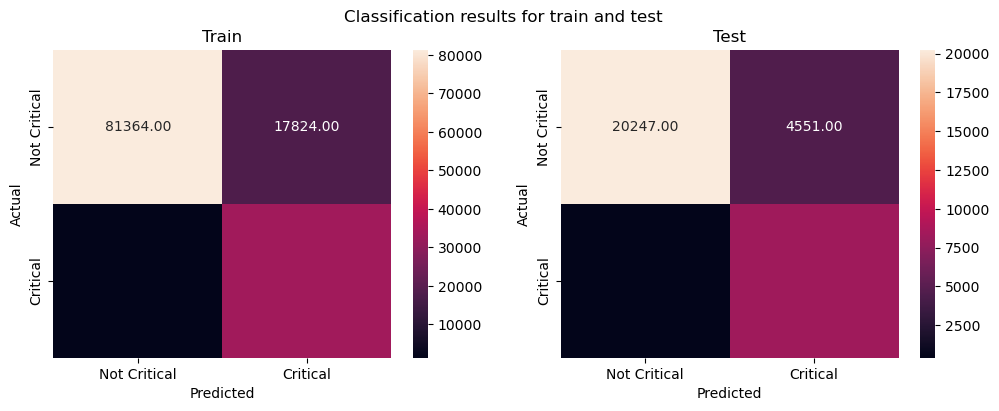

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.98      0.82      0.89     99188
           1       0.65      0.96      0.78     34632

    accuracy                           0.86    133820
   macro avg       0.82      0.89      0.84    133820
weighted avg       0.90      0.86      0.86    133820
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.98      0.82      0.89     24798
           1       0.64      0.95      0.77      8658

    accuracy                           0.85     33456
   macro avg       0.81      0.89      0.83     33456
weighted avg       0.89      0.85      0.86     33456



In [205]:
adjusted_metrics_plot(xgb, x_train_enc, x_test_enc, y_train, y_test)

+++++++++++++++++++++++ PERICISION/RECALL CURVE (TRAIN) +++++++++++++++++++++++



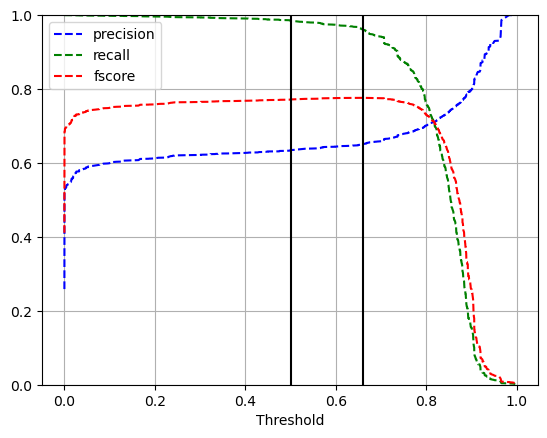


 ++++++++++++++++++++++++++++++++++++++++++++++ ROC-AUC ++++++++++++++++++++++++++++++++++++++++++++++

rocauc_train: 0.9285420375635421
rocauc_test: 0.9184089517684969

 ++++++++++++++++++++++++++++++++++++++++++++++ CONFUSION MTX ++++++++++++++++++++++++++++++++++++++++++++++



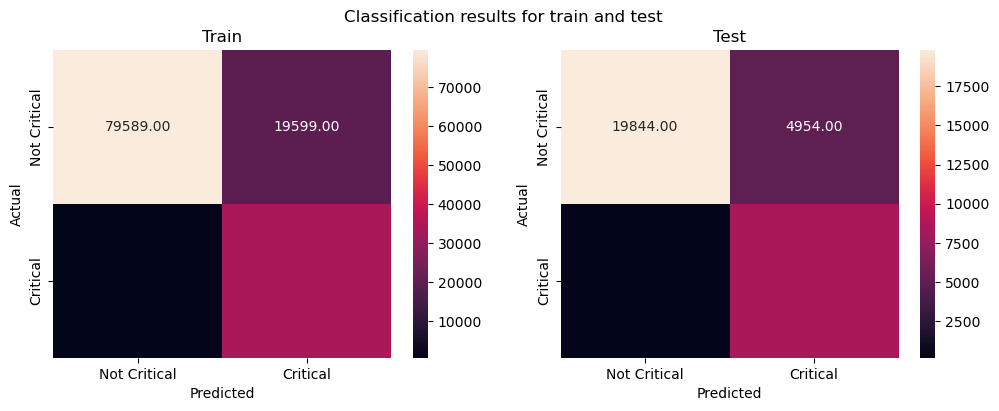

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.99      0.80      0.89     99188
           1       0.63      0.98      0.77     34632

    accuracy                           0.85    133820
   macro avg       0.81      0.89      0.83    133820
weighted avg       0.90      0.85      0.86    133820
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.99      0.80      0.89     24798
           1       0.63      0.98      0.77      8658

    accuracy                           0.85     33456
   macro avg       0.81      0.89      0.83     33456
weighted avg       0.90      0.85      0.86     33456

best_thr: 0.6607804894447327
best_fscore: 0.7762224710712953


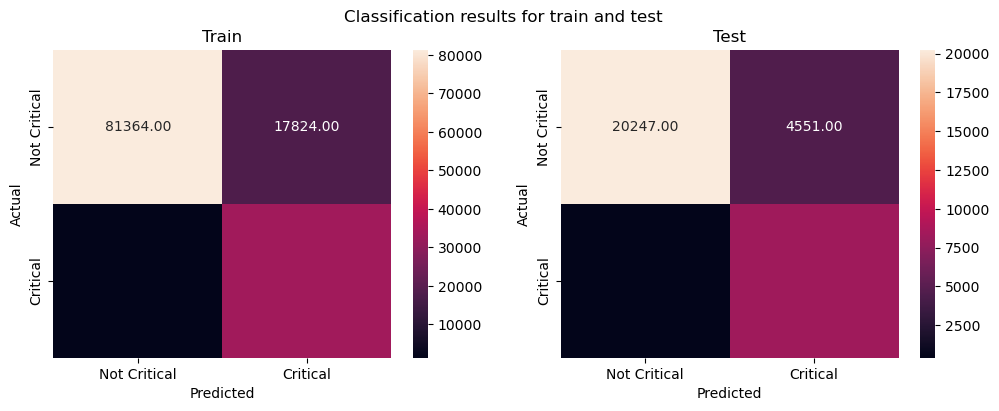

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.98      0.82      0.89     99188
           1       0.65      0.96      0.78     34632

    accuracy                           0.86    133820
   macro avg       0.82      0.89      0.84    133820
weighted avg       0.90      0.86      0.86    133820
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.98      0.82      0.89     24798
           1       0.64      0.95      0.77      8658

    accuracy                           0.85     33456
   macro avg       0.81      0.89      0.83     33456
weighted avg       0.89      0.85      0.86     33456


++++++++++++++++++++++++++++++++++++++++++++++ FEATURE IMPORTANCE ++++++++++++++++++++++++++++++++++++++++++++++



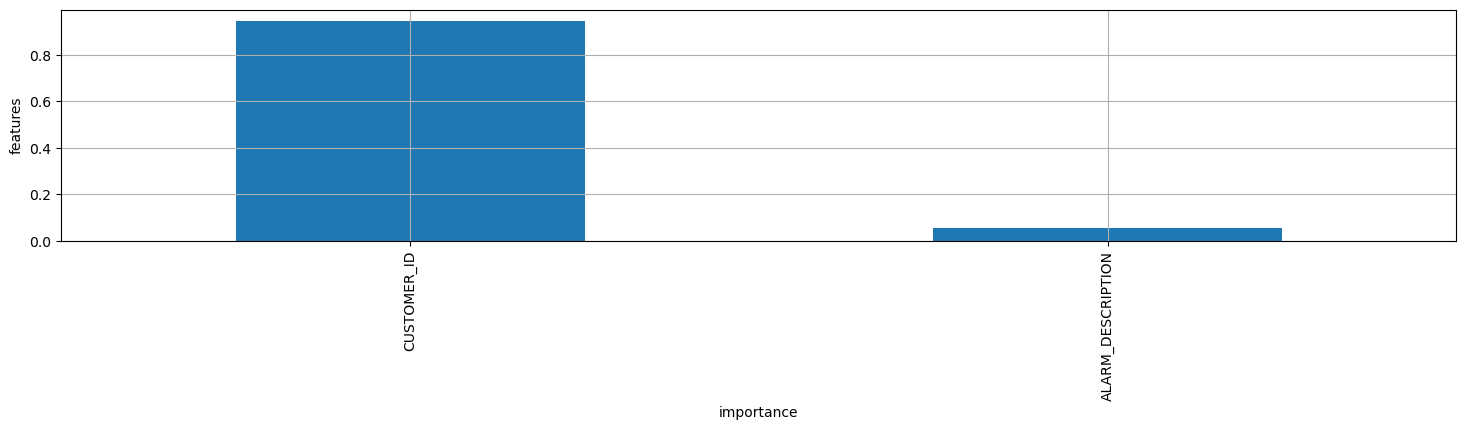


++++++++++++++++++++++++++++++++++++++++++++++ DECILE ANALYSIS ++++++++++++++++++++++++++++++++++++++++++++++



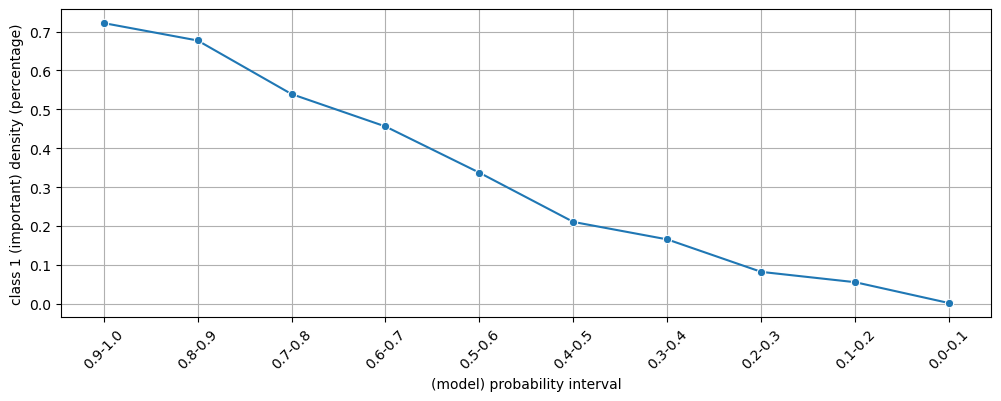

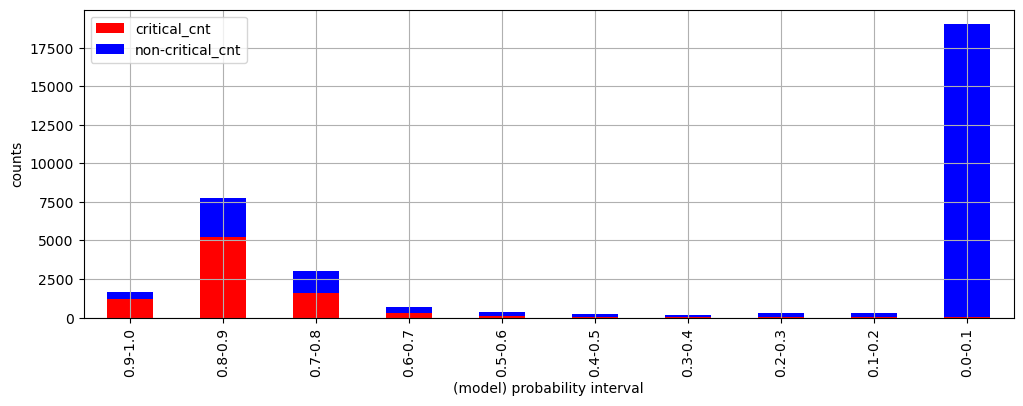

In [206]:
performance_summary(xgb, x_train_enc, x_test_enc, y_train, y_test)

In [207]:
# some stats from above figure (Decile analysis)
y_test_pred, y_test_score = get_prediction(xgb, x_test_enc)

thr = 0.35

missed_reds = ( (y_test_score[:,1] <= thr) & (y_test.values == 1) ).sum()
actual_reds = (y_test.values == 1).sum()
hit_blues = ( (y_test_score[:,1] <= thr) & (y_test.values == 0) ).sum()
actual_blues = (y_test.values == 0).sum()

print(f'''
    Example: choosing a threshold of 0.1 for making decision on criticality of alarm
     # of critical (red) alarm we would miss is {missed_reds} of all {actual_reds} critical alarms i.e. {missed_reds/actual_reds*100}%
     # of non-critical (blue) alarm we would supress is {hit_blues} of all {actual_blues} critical alarms i.e. {hit_blues/actual_blues*100}%
  ''')



    Example: choosing a threshold of 0.1 for making decision on criticality of alarm
     # of critical (red) alarm we would miss is 94 of all 8658 critical alarms i.e. 1.0857010857010856%
     # of non-critical (blue) alarm we would supress is 19610 of all 24798 critical alarms i.e. 79.0789579804823%
  


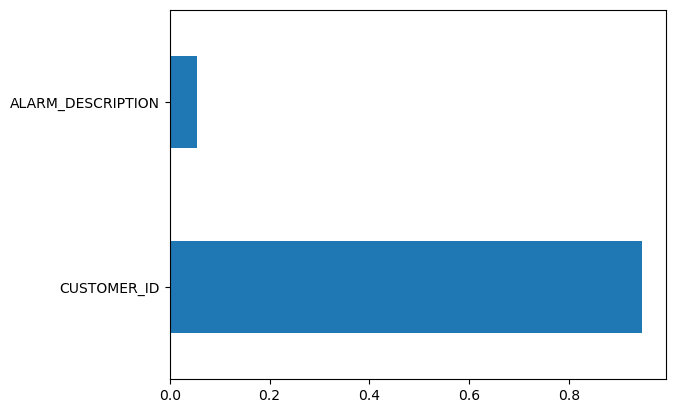

In [208]:
# feature imporrtances from the trained xgboost
pd.Series(xgb.feature_importances_, index=x_train_enc.columns).nlargest(len(xgb.feature_importances_)).plot(kind='barh')
plt.show()

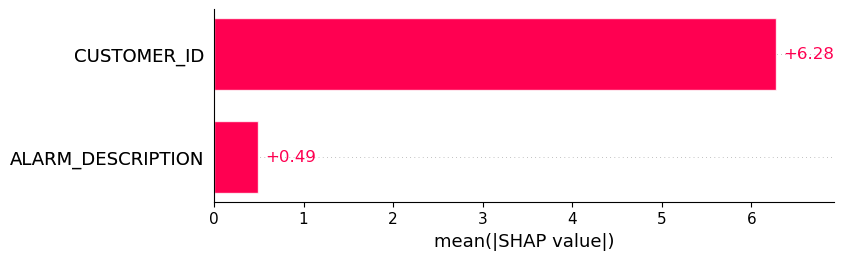

In [209]:
# feature importance from shap
explainer = shap.TreeExplainer(xgb)
shap_values =  explainer(x_test_enc)
shap.plots.bar(shap_values, max_display=8)

## What happens if TX_ID is not used
* TD_ID and ALARM_DETAILS are coming up as most important (no grouping)
* We have experimented with removing some of the columns and experiment with results (average f1-score)
* cuurent version: f1-test-macro = 0.83
* removing TX_ID:  f1-test-macro = 0.83 (makes sense as CUSTOMER_ID contains similar info)
* removing ALARM_DESCRIPTION: f1-test-macro = 0.83 (same performance, second position is now ALARM_DESCRIPTION). So basically most of the heavy work is done by location (TX_ID or CUSTOMER_ID) and alarm type ALARM_DESCRIPTION) but mostly first one.
* removing TX_ID, CUSTOMER_ID and ALARM_DETAILS (ZONE becomes first and ALARM_DESCRIPTION 2nd): f1-test-macro = 0.80
* removing TX_ID, CUSTOMER_ID and ALARM_DETAILS, Zone (ALARM_DESCRIPTION is top feature): f1-test-macro = 0.80: f1-test-macro = 0.73

* __NOTE: we would have obtained the best of above (f1-test-macro=0.83) only by using ALARM_DESCRIPTION and CUSTOMER_ID (basically alarm location and alarm type)__

## Possible Effect from Compression:

* Actual comepression mechanism is not known exactly
* TX_ID and ALARM_DESCRIPTION are related to location and alarm type
* Seems like it is not a complete set of features for grouping as sth related to equipment is needed
* ALARM_DESCRIPTION is not exactly that and is not 100% populated either. However it is the only column that might contain sometime the equipment info (in case)
* We examin compression based on above three columns to approximate an ideal compression.

In [215]:
grouped_data_1 = data_1.groupby(['CUSTOMER_ID','ALARM_DESCRIPTION','ALARM_DETAIL']).agg(
    reps = ('TX_ID', 'count'),
    num_unique_labels = ('ticket', lambda x:x.nunique()),
    unique_labels = ('ticket', lambda x:list(x.unique()))
).reset_index().sort_values(by='num_unique_labels')

In [217]:
grouped_data_1.head(10)

,CUSTOMER_ID,ALARM_DESCRIPTION,ALARM_DETAIL,reps,num_unique_labels,unique_labels
24686,XU0130,Equipment Fail,0:AC 9 SA FanTrble,1,1,[False]
24687,XU0130,Equipment Fail,0:CRAC 1 SA FanTrble,3,1,[False]
24688,XU0130,Equipment Fail,0:CRAC 3 SA FanTrble,5,1,[False]
24689,XU0130,Equipment Fail,0:CRAC 4 SA FanTrble,1,1,[False]
24690,XU0130,Equipment Fail,0:CRAC 9 SA FanTrble,6,1,[False]
24691,XU0130,Equipment Fail,1.#QNAN:AC 9 SA FanTrble,4,1,[False]
24692,XU0130,Equipment Fail,1.#QNAN:CRAC 7 SA FanTrble,6,1,[False]
24693,XU0130,Fire Alarm,nan,4,1,[False]
24678,XR2195,Equipment Fail,0:CWP03 Fail Flag,5,1,[False]
24679,XR2195,Equipment Fail,0:Chlr02 FailToRun,1,1,[False]


In [218]:
data_2 = data_1.merge(grouped_data_1, on=['CUSTOMER_ID','ALARM_DESCRIPTION','ALARM_DETAIL'], how='left')

In [219]:
data_2.head()

,CUSTOMER_ID,RLP,TX_ID,EVENT_DATE,EVENT_CODE,ALARM_DESCRIPTION,AREA,ZONE,ALARM_DETAIL,COMMENT,priority,ticket,reps,num_unique_labels,unique_labels
0,SYS-REC1,R1,0,2023-07-01 01:26:02,UT,Untyped Zone Trouble,nan,7,nan,nan,H,False,111,1,[False]
1,SYS-REC1,R1,0,2023-07-02 04:23:13,UT,Untyped Zone Trouble,nan,7,nan,nan,H,False,111,1,[False]
2,SYS-REC1,R1,0,2023-07-03 05:57:58,UT,Untyped Zone Trouble,nan,7,nan,fc,H,False,111,1,[False]
3,SYS-REC1,R1,0,2023-07-03 19:26:05,UT,Untyped Zone Trouble,nan,7,nan,nan,H,False,111,1,[False]
4,SYS-REC1,R1,0,2023-07-05 23:32:04,UT,Untyped Zone Trouble,nan,7,nan,fc,H,False,111,1,[False]


In [220]:
data_2.loc[(data_2.num_unique_labels == 2),'ticket'] = True

In [224]:
data_3 = grouped_data_1
data_3['ticket'] = data_3['unique_labels'].apply(lambda x:x[0] if len(x)==1 else True)

In [227]:
data_3.head()

,CUSTOMER_ID,ALARM_DESCRIPTION,ALARM_DETAIL,reps,num_unique_labels,unique_labels,ticket
24686,XU0130,Equipment Fail,0:AC 9 SA FanTrble,1,1,[False],False
24687,XU0130,Equipment Fail,0:CRAC 1 SA FanTrble,3,1,[False],False
24688,XU0130,Equipment Fail,0:CRAC 3 SA FanTrble,5,1,[False],False
24689,XU0130,Equipment Fail,0:CRAC 4 SA FanTrble,1,1,[False],False
24690,XU0130,Equipment Fail,0:CRAC 9 SA FanTrble,6,1,[False],False


In [231]:
data_1.ticket.value_counts(normalize=True)

ticket
False    0.741206
True     0.258794
Name: proportion, dtype: float64

In [232]:
data_2.ticket.value_counts(normalize=True)

ticket
False    0.581392
True     0.418608
Name: proportion, dtype: float64

In [233]:
data_3.ticket.value_counts(normalize=True)

ticket
False    0.705299
True     0.294701
Name: proportion, dtype: float64

In [234]:
feature_cols = ['CUSTOMER_ID','ALARM_DESCRIPTION','ALARM_DETAIL']
target = 'ticket'

In [235]:
X, Y = data_3[feature_cols], data_3[target].astype(int)

In [237]:
X.head(), Y.value_counts(normalize=True)

(      CUSTOMER_ID ALARM_DESCRIPTION          ALARM_DETAIL
 24686      XU0130    Equipment Fail    0:AC 9 SA FanTrble
 24687      XU0130    Equipment Fail  0:CRAC 1 SA FanTrble
 24688      XU0130    Equipment Fail  0:CRAC 3 SA FanTrble
 24689      XU0130    Equipment Fail  0:CRAC 4 SA FanTrble
 24690      XU0130    Equipment Fail  0:CRAC 9 SA FanTrble,
 ticket
 0    0.705299
 1    0.294701
 Name: proportion, dtype: float64)

In [240]:
x_train, x_test, y_train, y_test = split_data(X, Y, test_ratio=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((19762, 3), (4941, 3), (19762,), (4941,))

In [245]:
cat_cols = list(x_train.columns)
x_train_enc, x_test_enc = target_encode(x_train, x_test, y_train, cat_cols)

In [247]:
xgb =  train_model(x_train_enc, y_train)

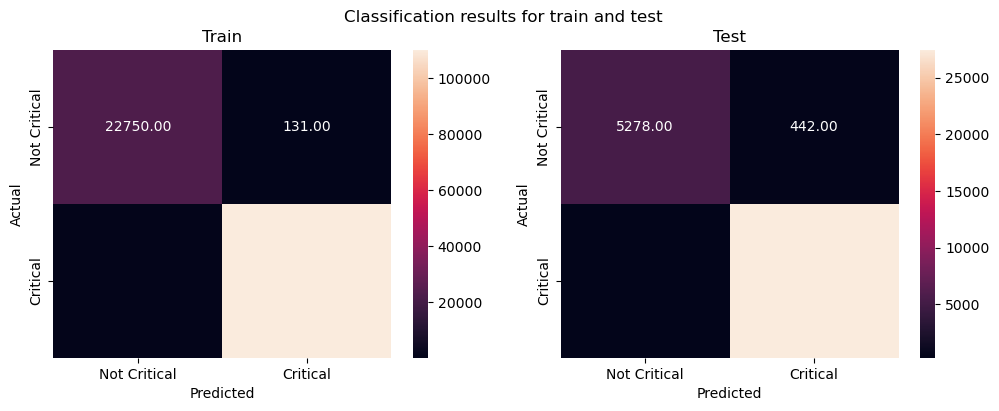

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     22881
           1       1.00      0.99      1.00    110939

    accuracy                           0.99    133820
   macro avg       0.98      0.99      0.99    133820
weighted avg       0.99      0.99      0.99    133820
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      5720
           1       0.98      0.99      0.99     27736

    accuracy                           0.98     33456
   macro avg       0.97      0.96      0.96     33456
weighted avg       0.98      0.98      0.98     33456



In [121]:
metrics_plot(xgb, x_train_enc, x_test_enc, y_train, y_test)

best_thr: 0.6485605239868164
best_fscore: 0.9913800460868822


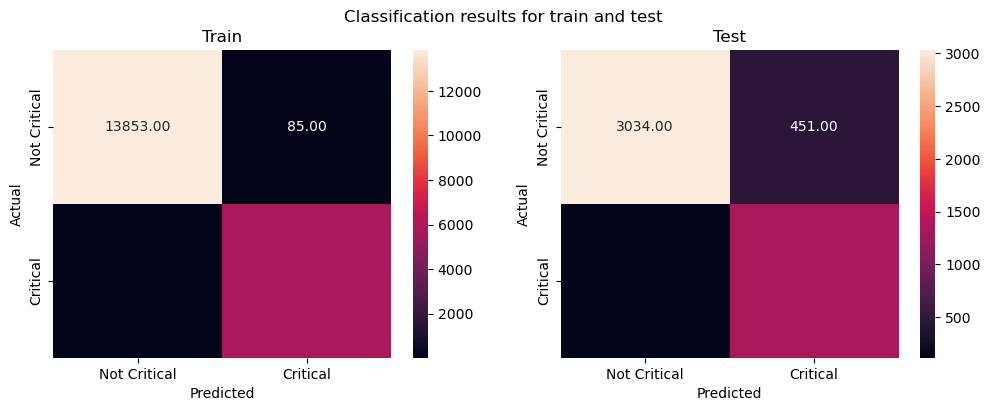

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     13938
           1       0.99      1.00      0.99      5824

    accuracy                           0.99     19762
   macro avg       0.99      1.00      0.99     19762
weighted avg       0.99      0.99      0.99     19762
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      3485
           1       0.75      0.92      0.83      1456

    accuracy                           0.89      4941
   macro avg       0.86      0.90      0.87      4941
weighted avg       0.90      0.89      0.89      4941



In [248]:
adjusted_metrics_plot(xgb, x_train_enc, x_test_enc, y_train, y_test)

+++++++++++++++++++++++ PERICISION/RECALL CURVE (TRAIN) +++++++++++++++++++++++



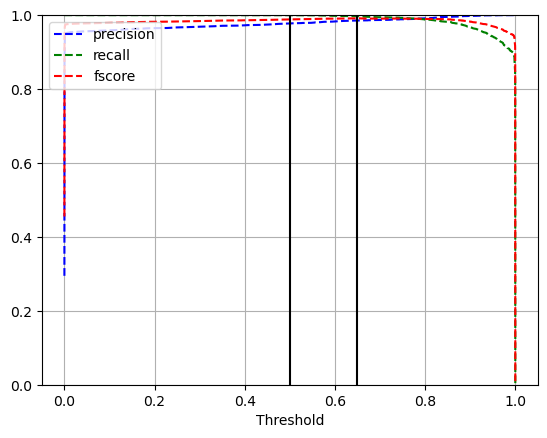


 ++++++++++++++++++++++++++++++++++++++++++++++ ROC-AUC ++++++++++++++++++++++++++++++++++++++++++++++

rocauc_train: 0.9998839974104314
rocauc_test: 0.9537054409005628

 ++++++++++++++++++++++++++++++++++++++++++++++ CONFUSION MTX ++++++++++++++++++++++++++++++++++++++++++++++



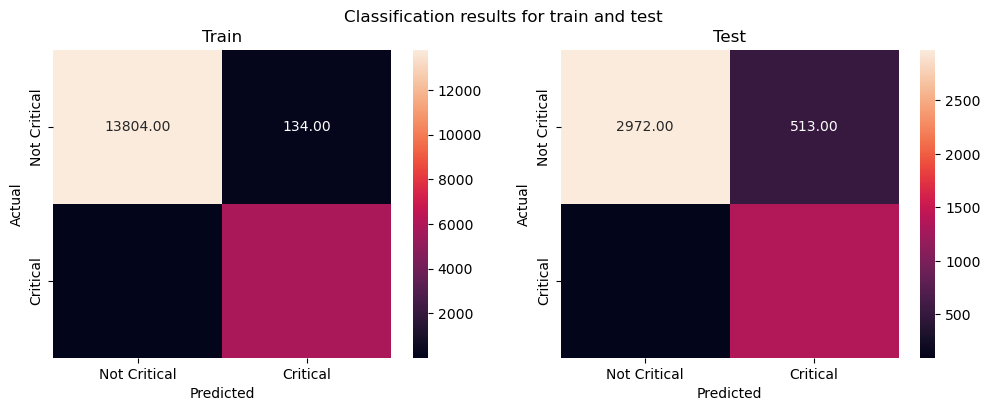

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     13938
           1       0.98      1.00      0.99      5824

    accuracy                           0.99     19762
   macro avg       0.99      1.00      0.99     19762
weighted avg       0.99      0.99      0.99     19762
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      3485
           1       0.73      0.93      0.82      1456

    accuracy                           0.88      4941
   macro avg       0.85      0.89      0.86      4941
weighted avg       0.90      0.88      0.88      4941

best_thr: 0.6485605239868164
best_fscore: 0.9913800460868822


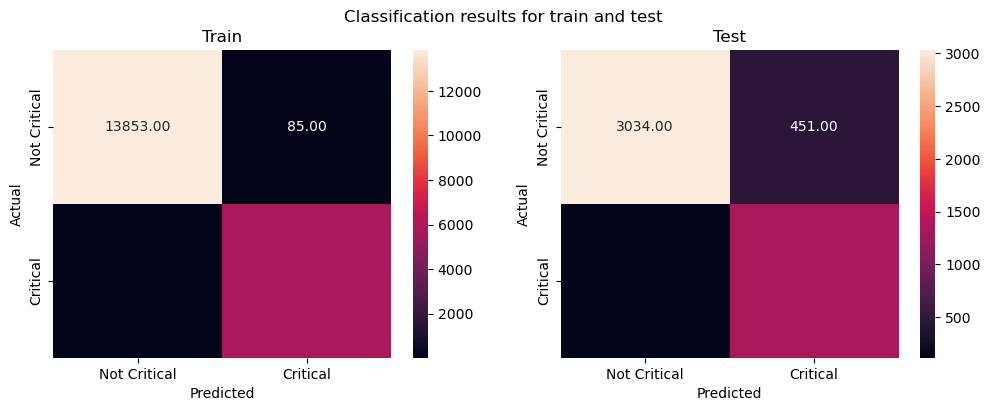

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     13938
           1       0.99      1.00      0.99      5824

    accuracy                           0.99     19762
   macro avg       0.99      1.00      0.99     19762
weighted avg       0.99      0.99      0.99     19762
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      3485
           1       0.75      0.92      0.83      1456

    accuracy                           0.89      4941
   macro avg       0.86      0.90      0.87      4941
weighted avg       0.90      0.89      0.89      4941


++++++++++++++++++++++++++++++++++++++++++++++ FEATURE IMPORTANCE ++++++++++++++++++++++++++++++++++++++++++++++



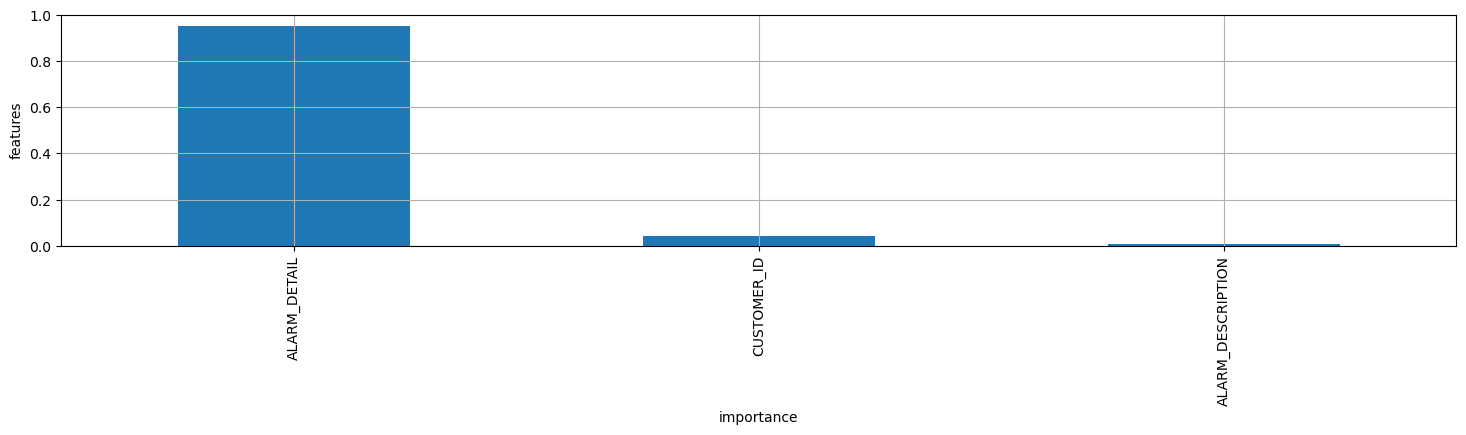


++++++++++++++++++++++++++++++++++++++++++++++ DECILE ANALYSIS ++++++++++++++++++++++++++++++++++++++++++++++



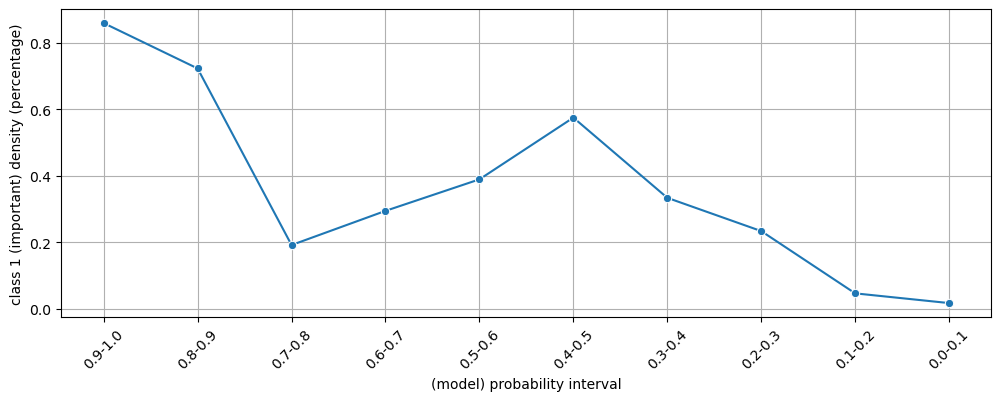

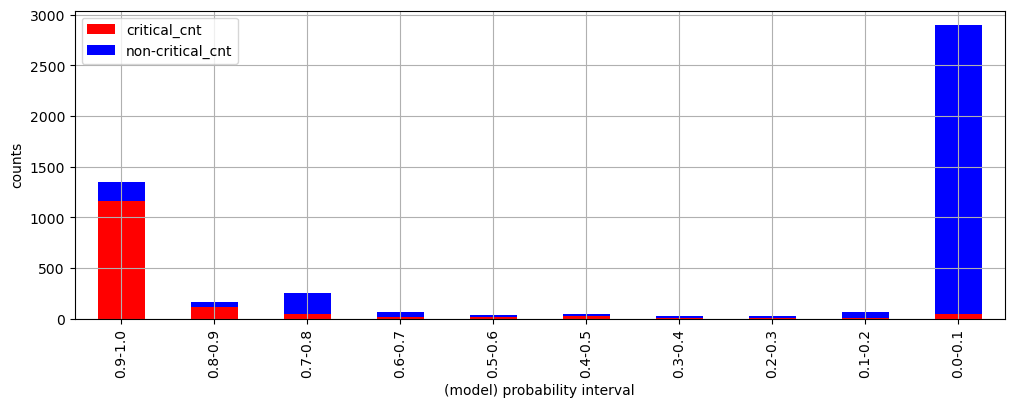

In [249]:
performance_summary(xgb, x_train_enc, x_test_enc, y_train, y_test)

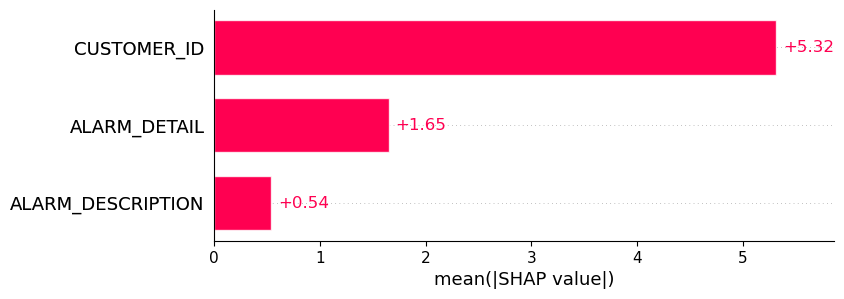

In [250]:
explainer = shap.Explainer(xgb)
shap_values = explainer(x_test_enc)
shap_values.shape
shap.plots.bar(shap_values)

# Registering last version and endpoint creation

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import os
import pandas as pd
import mlflow
import mlflow.sklearn
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
import shap
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import warnings
warnings.filterwarnings('ignore')

The scikit-learn version is 1.3.0.


In [3]:
# authenticate
credential = DefaultAzureCredential()
SUBSCRIPTION = "6a0b08ba-398e-41e1-82bf-ba3b062396db"
RESOURCE_GROUP = "US-SmartFM-DEV-RG"
WS_NAME = "mlw-smartfm-nonprod"

ml_client = MLClient(
    credential=credential,
    subscription_id=SUBSCRIPTION,
    resource_group_name=RESOURCE_GROUP,
    workspace_name=WS_NAME,
)
ws = ml_client.workspaces.get(WS_NAME)
print(ws.location, ":", ws.resource_group)

centralus : US-SmartFM-DEV-RG


Transient server side error 429: {"itemsReceived":1,"itemsAccepted":0,"appId":null,"errors":[{"index":0,"statusCode":429,"message":"Too much data"}]}. Retrying.


In [9]:
train_src_dir = "ATT_V0/src"
os.makedirs(train_src_dir, exist_ok=True)

In [8]:
data='./ATT_Sample_Data/att_sample_data_raw.csv'
n_estimators=100
learning_rate=0.25
registered_model_name = "att_poc_model_v0"

In [6]:
mlflow.start_run()
mlflow.sklearn.autolog()

2024/04/12 00:29:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [7]:
# Sample data uploaded (3 month)
data_1 = pd.read_csv(data)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167276 entries, 0 to 167275
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   CUSTOMER_SERIAL_NO  167276 non-null  int64 
 1   CUSTOMER_ID         167276 non-null  object
 2   RLP                 167276 non-null  object
 3   TX_ID               165683 non-null  object
 4   EVENT_DATE          167276 non-null  object
 5   EVENT_CODE          167276 non-null  object
 6   ALARM_DESCRIPTION   167276 non-null  object
 7   AREA                31108 non-null   object
 8   ZONE                161187 non-null  object
 9   ALARM_DETAIL        149074 non-null  object
 10  COMMENT             154014 non-null  object
 11  COMMENT_LOGDATE     154113 non-null  object
dtypes: int64(1), object(11)
memory usage: 15.3+ MB


In [8]:
data_1['priority'] = 'H'
inds = data_1[data_1.EVENT_CODE.isin(['DI','DI1','DI2','ET1','*T2','DV','FT','*FT','TB1'])].index
data_1.loc[data_1.index.isin(inds),"priority"]= 'L'

In [9]:
data_1[['CUSTOMER_ID','RLP','TX_ID','EVENT_CODE','ALARM_DESCRIPTION','AREA','ZONE','ALARM_DETAIL'
        ,'COMMENT','priority']] = data_1[['CUSTOMER_ID','RLP','TX_ID','EVENT_CODE','ALARM_DESCRIPTION','AREA','ZONE','ALARM_DETAIL','COMMENT','priority']].astype(str)

In [10]:
data_1 = data_1.drop(['CUSTOMER_SERIAL_NO','COMMENT_LOGDATE'], axis=1)

In [11]:
def get_ticket_info(txt):
    # sequence of exactly 16 digits that is not preceded or followed by any other digit
    str_exp = r'(?<!\d)\d{16}(?!\d)'
    tickets = re.findall(str_exp, txt)
    tickets = [item.strip() for item in tickets]
    return len(tickets)>0
    
data_1['ticket'] = data_1['COMMENT'].astype('str').apply(get_ticket_info)

data_1['ticket'].value_counts(normalize=True)

ticket
False    0.741206
True     0.258794
Name: proportion, dtype: float64

In [12]:
grouped_data_1 = data_1.groupby(['CUSTOMER_ID','ALARM_DESCRIPTION','ALARM_DETAIL']).agg(
    reps = ('TX_ID', 'count'),
    num_unique_labels = ('ticket', lambda x:x.nunique()),
    unique_labels = ('ticket', lambda x:list(x.unique()))
).reset_index().sort_values(by='num_unique_labels')

data_3 = grouped_data_1
data_3['ticket'] = data_3['unique_labels'].apply(lambda x:x[0] if len(x)==1 else True)

In [13]:
feature_cols = ['CUSTOMER_ID','ALARM_DESCRIPTION','ALARM_DETAIL']

target = 'ticket'
X, Y = data_3[feature_cols], data_3[target].astype(int)

In [14]:
def split_data(features, target, test_ratio):
    
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=test_ratio, train_size=1-test_ratio, random_state=7, shuffle=True, stratify=target)
    
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data(X, Y, test_ratio=0.2)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(19762, 3) (4941, 3) (19762,) (4941,)


In [15]:
def target_encode(x_train, x_test, y_train, cat_cols):
    
    target_encoder = TargetEncoder().fit(x_train[cat_cols],y_train)
    
    x_train_enc = pd.DataFrame(target_encoder.transform(x_train[cat_cols]), columns = cat_cols)
    x_test_enc = pd.DataFrame(target_encoder.transform(x_test[cat_cols]), columns = cat_cols)
    
    x_train_enc = pd.concat([x_train_enc, x_train.drop(cat_cols,axis=1)], axis=1)
    x_test_enc = pd.concat([x_test_enc, x_test.drop(cat_cols,axis=1)], axis=1)
    
    return x_train_enc, x_test_enc

cat_cols = list(x_train.columns)
x_train_enc, x_test_enc = target_encode(x_train, x_test, y_train, cat_cols)

In [16]:
def train_model(x_train_enc, y_train,n_estimators,learning_rate):
    gbc = GradientBoostingClassifier(
        n_estimators=n_estimators, learning_rate=learning_rate
    )
    gbc.fit(x_train_enc, y_train)
    return gbc

In [17]:
def get_prediction(model, features):
    return model.predict(features), model.predict_proba(features)

In [18]:
def metrics_plot(model, x_train_enc, x_test_enc, y_train, y_test):
    
    y_train_pred, y_train_score = get_prediction(model, x_train_enc)
    y_test_pred, y_test_score = get_prediction(model, x_test_enc)
    
    actual, predicted, actual_te, predicted_te = y_train, y_train_pred, y_test, y_test_pred
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    fig.suptitle('Classification results for train and test')
    
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not Critical', 'Critical'], yticklabels = ['Not Critical', 'Critical'], ax=axes[0])
    axes[0].set_title('Train')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    cm_te = confusion_matrix(actual_te, predicted_te)
    sns.heatmap(cm_te, annot = True, fmt = '.2f', xticklabels = ['Not Critical', 'Critical'], yticklabels = ['Not Critical', 'Critical'], ax=axes[1])
    axes[1].set_title('Test')
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')
    
    plt.show()
    
    print(f'+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++\n',
          classification_report(actual, predicted),
          f'\n+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++\n',
          classification_report(actual_te, predicted_te))



def adjusted_metrics_plot(model, x_train_enc, x_test_enc, y_train, y_test):
    
    y_train_pred, y_train_score = get_prediction(model, x_train_enc)
    y_test_pred, y_test_score = get_prediction(model, x_test_enc)
    
    actual, predicted_prob, actual_te, predicted_prob_te = y_train, y_train_score[:,1], y_test, y_test_score[:,1]

    precision, recall, thresholds = precision_recall_curve(actual, predicted_prob)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    best_threshold, best_fscore = thresholds[ix], fscore[ix]
    print(f'best_thr: {best_threshold}\nbest_fscore: {best_fscore}')
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    fig.suptitle('Classification results for train and test')
    
    y_pred_adj = np.where(predicted_prob >= best_threshold, 1,0)
    cm = confusion_matrix(actual, y_pred_adj)
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not Critical', 'Critical'], yticklabels = ['Not Critical', 'Critical'], ax=axes[0])
    axes[0].set_title('Train')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    
    y_pred_adj_te = np.where(predicted_prob_te >= best_threshold, 1,0)
    cm_te = confusion_matrix(actual_te, y_pred_adj_te)
    sns.heatmap(cm_te, annot = True, fmt = '.2f', xticklabels = ['Not Critical', 'Critical'], yticklabels = ['Not Critical', 'Critical'], ax=axes[1])
    axes[1].set_title('Test')
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')
    
    plt.show()
    
    print(f'+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++\n',
          classification_report(actual, y_pred_adj),
          f'\n+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++\n',
          classification_report(actual_te, y_pred_adj_te))

In [20]:
gbc = train_model(x_train_enc, y_train, n_estimators, learning_rate)

2024/04/12 00:32:34 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': None, 'Details': [], 'InnerError': None, 'DebugInfo': None, 'AdditionalInfo': None}, 'Correlation': {'operation': '19e735567eefb365ca0569a84c743011', 'request': 'fcfd0a12a6e14ef0'}, 'Environment': 'centralus', 'Location': 'centralus', 'Time': '2024-04-12T00:32:34.2805723+00:00', 'ComponentName': 'mlflow', 'statusCode': 400, 'error_code': 'BAD_REQUEST'}
2024/04/12 00:32:34 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageP

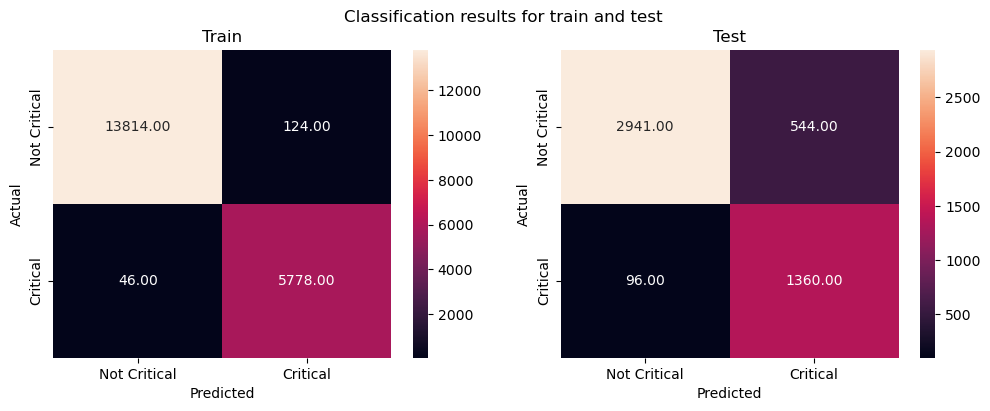

+++++++++++++++++++++++ TRAIN REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     13938
           1       0.98      0.99      0.99      5824

    accuracy                           0.99     19762
   macro avg       0.99      0.99      0.99     19762
weighted avg       0.99      0.99      0.99     19762
 
+++++++++++++++++++++++ TEST REPORT +++++++++++++++++++++++
               precision    recall  f1-score   support

           0       0.97      0.84      0.90      3485
           1       0.71      0.93      0.81      1456

    accuracy                           0.87      4941
   macro avg       0.84      0.89      0.86      4941
weighted avg       0.89      0.87      0.87      4941



In [21]:
metrics_plot(gbc, x_train_enc, x_test_enc, y_train, y_test)

In [22]:
print("Registering the model via MLFlow")
mlflow.sklearn.log_model(
    sk_model=gbc,
    registered_model_name=registered_model_name,
    artifact_path=registered_model_name,
)

Registering the model via MLFlow


Registered model 'att_poc_model_v0' already exists. Creating a new version of this model...
2024/04/12 00:33:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: att_poc_model_v0, version 2
Created version '2' of model 'att_poc_model_v0'.


In [23]:
mlflow.sklearn.save_model(
    sk_model=gbc,
    path=os.path.join('ATT_V0',registered_model_name, "trained_model"),
)

In [24]:
mlflow.end_run()

In [4]:
import uuid
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
)

In [2]:
# Creating a unique name for the endpoint
online_endpoint_name = "att-endpoint-" + str(uuid.uuid4())[:8]
print(online_endpoint_name)

att-endpoint-7efdd221


In [5]:
online_endpoint_name = 'att-endpoint-7efdd221'

In [4]:
# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="online endpoint for att_model",
    auth_mode="key",
    tags={
        "training_dataset": "att_sample_data",
        "model_type": "sklearn.GradientBoostingClassifier",
    },
)

In [11]:
endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()
print(f"Endpoint {endpoint.name} provisioning state: {endpoint.provisioning_state}")

Endpoint att-endpoint-7efdd221 provisioning state: Succeeded


In [6]:
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)
print(
    f'Endpoint "{endpoint.name}" with provisioning state "{endpoint.provisioning_state}" is retrieved'
)

Endpoint "att-endpoint-7efdd221" with provisioning state "Succeeded" is retrieved


In [9]:
# Let's pick the latest version of the model
latest_model_version = max(
    [int(m.version) for m in ml_client.models.list(name=registered_model_name)]
)
print(f'Latest model is version "{latest_model_version}" ')

Latest model is version "2" 


In [10]:
# picking the model to deploy. Here we use the latest version of our registered model
model = ml_client.models.get(name=registered_model_name, version=latest_model_version)

In [11]:
# create an online deployment.
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_DS3_v2",
    instance_count=1,
)

In [12]:
blue_deployment = ml_client.begin_create_or_update(blue_deployment).result()

Check: endpoint att-endpoint-7efdd221 exists


..........................................................................................

HttpResponseError: (None) ResourceNotReady: User container has crashed or terminated: Liveness probe failed: Get http://10.66.0.2:5001/: dial tcp 10.66.0.2:5001: connect: connection refused. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotready
Code: None
Message: ResourceNotReady: User container has crashed or terminated: Liveness probe failed: Get http://10.66.0.2:5001/: dial tcp 10.66.0.2:5001: connect: connection refused. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotready
Exception Details:	(None) ResourceNotReady: User container has crashed or terminated: Liveness probe failed: Get http://10.66.0.2:5001/: dial tcp 10.66.0.2:5001: connect: connection refused. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotready
	Code: None
	Message: ResourceNotReady: User container has crashed or terminated: Liveness probe failed: Get http://10.66.0.2:5001/: dial tcp 10.66.0.2:5001: connect: connection refused. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotready

In [13]:
# deploy_dir = "./deploy"
# os.makedirs(deploy_dir, exist_ok=True)

In [14]:
# %%writefile {deploy_dir}/sample-request.json
# {
#   "input_data": {
#     "columns": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
#     "index": [0, 1],
#     "data": [
#             [20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0],
#             [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8]
#         ]
#   }
# }

In [15]:
# # test the blue deployment with some sample data
# ml_client.online_endpoints.invoke(
#     endpoint_name=online_endpoint_name,
#     request_file="./deploy/sample-request.json",
#     deployment_name="blue",
# )

In [16]:
# ml_client.online_endpoints.begin_delete(name=online_endpoint_name)